In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px

sns.set_theme()

# Functions

In [2]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['iso3','hdicode','region','year'], columns='indicator_name', values='value').reset_index()
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    df_r.drop(columns=['index'], inplace=True)
    df_r['year'] = pd.to_datetime(df_r['year'], format='%Y',errors='coerce').dt.year
    return df_r

In [3]:
def Gap(df: pd.DataFrame, inds: list[str]) -> pd.DataFrame:
    """
    For each iso3, find the overall min and max year in df,
    then for each indicator in inds compute newest – oldest.
    
    Returns a DataFrame with columns:
      iso3, min_year, max_year,
      oldest_<ind>, newest_<ind>, <ind>_diff  (one set per indicator)
    """
    # 1) Find global min and max year per country
    year_range = (
        df.groupby('iso3')['year']
          .agg(min_year='min', max_year='max')
          .reset_index()
    )
    
    # 2) Pull out oldest rows
    oldest = (
        df.merge(year_range, on='iso3')
          .query("year == min_year")
          .loc[:, ['iso3', 'year'] + inds]
          .rename(columns={ 'year': 'min_year', 
                            **{ind: f'oldest_{ind}' for ind in inds}})
    )
    
    # 3) Pull out newest rows
    newest = (
        df.merge(year_range, on='iso3')
          .query("year == max_year")
          .loc[:, ['iso3', 'year'] + inds]
          .rename(columns={ 'year': 'max_year', 
                            **{ind: f'newest_{ind}' for ind in inds}})
    )
    
    # 4) Merge them all together
    result = (
        year_range
        .merge(oldest, on='iso3')
        .merge(newest, on='iso3')
    )
    
    # 5) Compute diffs
    for ind in inds:
        result[f'{ind}_diff'] = result[f'newest_{ind}'] - result[f'oldest_{ind}']
    
    return result

# Example usage:
# df has columns ['iso3','year','logGDP','pop','ind1',...]
# gaps = Gap(df, ['logGDP','pop'])


In [4]:
def PrepareData(df,ind): # Function to prepare the data for analysis
    Panel = df.copy()
    shift = ind.replace('_value', '') + '_shifted'
    Panel[shift] = Panel.groupby('iso3')[ind].shift(1)
    Panel.dropna(subset = shift ,inplace=True) # Drop rows with NaN values
    return Panel

In [5]:
def Regression(Panel,independent_vars,dependent_var): # Function to run the regression
    L = ['iso3','year']
    L.extend(independent_vars)
    L.append(dependent_var)
    model_df = Panel[L].copy()
    model_df = model_df.set_index(['iso3', 'year'])
    # Drop rows with NaN values only in the independent and dependent variable columns
    model_df = model_df.dropna(subset=independent_vars + [dependent_var])
    model_df[independent_vars] = model_df[independent_vars].apply(pd.to_numeric, errors='coerce')
    model_df[dependent_var] = model_df[dependent_var].apply(pd.to_numeric, errors='coerce')

    Y = model_df[dependent_var]
    X = model_df[independent_vars]
    X = sm.add_constant(X)

    mod_fe = PanelOLS(Y,X, entity_effects=True, time_effects=True)
    results = mod_fe.fit(cov_type='clustered',cluster_entity=True)

    return results.summary

In [6]:
def GapShared(df1: pd.DataFrame, ind1: str,
              df2: pd.DataFrame, ind2: str) -> pd.DataFrame:
    """
    For each iso3, find the overlapping year range between df1 and df2,
    then compute for both indicators at the start and end of that range:
      - <ind>_start, <ind>_end, <ind>_diff
    Returns a DataFrame with columns:
      iso3, common_start_year, common_end_year,
      start_<ind1>, end_<ind1>, diff_<ind1>,
      start_<ind2>, end_<ind2>, diff_<ind2>
    """
    # 1) Compute min/max years per iso3 in each dataset
    df1 = df1.dropna(subset=[ind1])
    df2 = df2.dropna(subset=[ind2])
    y1 = df1.groupby('iso3')['year'].agg(min1='min', max1='max').reset_index()
    y2 = df2.groupby('iso3')['year'].agg(min2='min', max2='max').reset_index()

    # 2) Merge to get per-iso3 common span
    yrs = pd.merge(y1, y2, on='iso3', how='inner')
    yrs['common_start_year'] = yrs[['min1', 'min2']].max(axis=1)
    yrs['common_end_year']   = yrs[['max1', 'max2']].min(axis=1)

    # 3) Filter to only those with a valid overlap
    valid = yrs[yrs['common_start_year'] <= yrs['common_end_year']]

    # 4) Prepare df1 oldest and newest at shared years
    df1_ext = pd.merge(df1, valid[['iso3', 'common_start_year', 'common_end_year']], on='iso3')
    oldest1 = df1_ext[df1_ext['year'] == df1_ext['common_start_year']][['iso3', ind1]]
    newest1 = df1_ext[df1_ext['year'] == df1_ext['common_end_year']][['iso3', ind1]]
    oldest1 = oldest1.rename(columns={ind1: f'start_{ind1}'})
    newest1 = newest1.rename(columns={ind1: f'end_{ind1}'})

    # 5) Prepare df2 oldest and newest at shared years
    df2_ext = pd.merge(df2, valid[['iso3', 'common_start_year', 'common_end_year']], on='iso3')
    oldest2 = df2_ext[df2_ext['year'] == df2_ext['common_start_year']][['iso3', ind2]]
    newest2 = df2_ext[df2_ext['year'] == df2_ext['common_end_year']][['iso3', ind2]]
    oldest2 = oldest2.rename(columns={ind2: f'start_{ind2}'})
    newest2 = newest2.rename(columns={ind2: f'end_{ind2}'})

    # 6) Merge all parts
    result = valid[['iso3', 'common_start_year', 'common_end_year']]
    result = result.merge(oldest1, on='iso3')
    result = result.merge(newest1, on='iso3')
    result[f'diff_{ind1}'] = result[f'end_{ind1}'] - result[f'start_{ind1}']

    result = result.merge(oldest2, on='iso3')
    result = result.merge(newest2, on='iso3')
    result[f'diff_{ind2}'] = result[f'end_{ind2}'] - result[f'start_{ind2}']

    return result


In [7]:
def calculate_vif(df: pd.DataFrame) -> pd.Series:
    """
    Calculate VIF for each column in df.
    Returns a pd.Series indexed by column names.
    """
    vif = pd.Series(
        [variance_inflation_factor(df.values, i) for i in range(df.shape[1])],
        index=df.columns,
        name="VIF"
    )
    return vif

def vif_selection(
    X: pd.DataFrame,
    thresh: float = 10.0,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Recursively drop the feature with the highest VIF until all VIFs <= thresh.

    Parameters
    ----------
    X : pd.DataFrame
        The design matrix (should be scaled if you want to include intercept)
    thresh : float, default 10.0
        VIF threshold. Variables with VIF > thresh will be removed.
    verbose : bool, default True
        If True, prints each dropped feature and its VIF.

    Returns
    -------
    pd.DataFrame
        Subset of X with all VIFs <= thresh.
    """
    # Work on a copy so we don't modify the original
    X = X.copy()
    # If you’ve already added an intercept column, drop it before VIF calc
    if 'Intercept' in X.columns:
        X = X.drop(columns='Intercept')

    # Calculate current VIFs
    vif = calculate_vif(X)
    max_vif = vif.max()

    # Base case: all VIFs below threshold
    if max_vif <= thresh:
        if verbose:
            print("All VIFs are below threshold.")
        return X

    # Otherwise drop the worst offender and recurse
    worst_feature = vif.idxmax()
    if verbose:
        print(f"Dropping '{worst_feature}' (VIF = {max_vif:.2f})")
    X = X.drop(columns=worst_feature)

    return vif_selection(X, thresh=thresh, verbose=verbose)

In [8]:
def pvalue_selection(
    X: pd.DataFrame,
    y: pd.Series,
    thresh: float = 0.05,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Iteratively drops the predictor with the highest p-value until
    all predictors have p-value <= thresh.

    Parameters
    ----------
    X : pd.DataFrame
        Predictor matrix (not including the constant).
    y : pd.Series
        Response variable.
    thresh : float, default 0.05
        Maximum allowed p-value.
    verbose : bool, default True
        If True, prints each dropped variable and its p-value.

    Returns
    -------
    pd.DataFrame
        Subset of X whose OLS p-values are all <= thresh (plus a constant column).
    """
    X = X.copy()
    # always include constant in the model
    X_const = sm.add_constant(X, has_constant='add')

    while True:
        model = sm.OLS(y, X_const).fit()
        pvals = model.pvalues.drop('const', errors='ignore')  # ignore intercept
        max_p = pvals.max()

        # if the worst p-value is within threshold, we’re done
        if max_p <= thresh:
            if verbose:
                print("All predictors have p-value ≤", thresh)
            break

        # otherwise drop the predictor with the largest p-value
        worst = pvals.idxmax()
        if verbose:
            print(f"Dropping '{worst}' (p = {max_p:.4f})")
        X_const = X_const.drop(columns=[worst])

    return X_const



# Data loading and preparation

## Data Loading

In [9]:
path = 'Datasets/'
image_path = '/Users/gianlucafilesi/Library/CloudStorage/OneDrive-EDHEC/04 THESIS/Images/Results/'

gdp_pc_ppp = pd.read_csv(path + 'GDP per capita, PPP (current international)/WB_WDI_NY_GDP_PCAP_PP_CD.csv') # GDP per capita, PPP (current international $)
hdr = pd.read_csv(path + 'HDR/HDR25_Composite_indices_complete_time_series.csv',encoding='latin1') # Human Development Index
hdr_labels = pd.read_excel(path + 'HDR/HDR25_Composite_indices_metadata.xlsx', sheet_name = 'codebook') # Human Development
schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data
schooling_labels = pd.read_csv(path+'UNESCO/OPRI_LABEL.csv') # Schooling labels
gs = pd.read_csv(path + 'GenderStatistics/GS.csv') # Globalization data

/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_8712/260420088.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data


## Data preparation

In [10]:
GS = gs.copy()
GS = GS.drop(columns=['Unnamed: 0'])
GS = GS.rename(columns={'REF_AREA': 'iso3', 'YEAR': 'year'})

### HDR

In [11]:
HDR_ISO_country = {hdr['iso3'][i]:hdr['country'][i] for i in range(len(hdr))}

In [12]:
hdr_labels.drop(columns=['Time series'], inplace=True)
hdr_labels.dropna(subset=['Short name'], inplace=True)
hdr_labels.rename(columns={'Full name': 'indicator_name', 'Short name': 'indicator'}, inplace=True)

In [13]:
HDR = hdr.copy()
df_melted = HDR.melt(id_vars=['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2023'], var_name='indicator_year', value_name='value') # Melt the dataframe to long format
df_melted[['indicator', 'year']] = df_melted['indicator_year'].str.extract(r'([a-z0-9_]+)_(\d{4})')
df_final = df_melted[['iso3','hdicode','region','year', 'indicator', 'value']] # Reorder and select final columns
HDR = pd.merge(hdr_labels, df_final, on=['indicator'], how='right') # Merge with labels

In [14]:
North_America = ['Canada','United States'] 
Oceania = ['Australia','New Zealand'] 
Asia = ['Hong Kong, China (SAR)','Korea (Republic of)','Japan'] 
Europe_Central_Asia = ['Cyprus','Russian Federation','Israel'] 
Weastern_Europe = ['Andorra', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 
                   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 
                   'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 
                   'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'San Marino', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland','United Kingdom']
Arab_states = ['Algeria', 'Bahrain', 'Djibouti', 'Egypt', 'Iraq', 'Jordan']
Areas = ['Very high human development', 'High human development',
       'Medium human development', 'Low human development', 'Arab States',
       'East Asia and the Pacific', 'Europe and Central Asia',
       'Latin America and the Caribbean', 'South Asia',
       'Sub-Saharan Africa', 'World']

In [15]:
region_labels = {
    'ECA': 'Europe & Central Asia',
    'AS':  'Arab States',
    'SSA': 'Sub-Saharan Africa', 
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'EAP': 'East Asia & Pacific',
    'AS':  'Arab States',
    'NA': 'North America',
    'WE': 'Western Europe',
    'OC': 'Oceania'
}

In [16]:
h = HDR[HDR['region'].isna()].copy()
h.loc[:,'region'] = h.loc[:,'iso3'].apply(assign_region)
HDR = pd.concat([HDR[~HDR['region'].isna()], h], ignore_index=True) # Concatenate the two dataframes
HDR.dropna(subset=['value'], inplace=True) # Drop rows with NaN values in the region column
HDR = HDR[HDR['region'] != 'AREA']

NameError: name 'assign_region' is not defined

In [ ]:
HDI_indicators = ['hdi', 'le', 'eys', 'mys', 'gnipc']
GDI_indicators = ['gdi_group', 'gdi', 'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m', 'mys_m', 'gni_pc_m']
IHDI_indicators = ['ihdi', 'coef_ineq', 'loss', 'ineq_le', 'ineq_edu', 'ineq_inc']
GII_indicators = ['gii_rank', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f', 'pr_m', 'lfpr_f', 'lfpr_m']
PHDI_indicators = ['rankdiff_hdi_phdi', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf']
Population_indicator = ['pop_total']

In [ ]:
hdi = HDR[HDR['indicator'].isin(HDI_indicators+Population_indicator)]
gdi = HDR[HDR['indicator'].isin(GDI_indicators+Population_indicator)]
ihdi = HDR[HDR['indicator'].isin(IHDI_indicators+Population_indicator)]
gii = HDR[HDR['indicator'].isin(GII_indicators+Population_indicator)]
phdi = HDR[HDR['indicator'].isin(PHDI_indicators+Population_indicator)]

In [ ]:
HDI = Pivoting(hdi)
GDI = Pivoting(gdi)
IHDI = Pivoting(ihdi)
GII = Pivoting(gii)

In [ ]:
HDR_idx = {'hdi': 'Human Development Index (value)', 'gii': 'Gender Inequality Index (value)', 
           'gdi': 'Gender Development Index (value)', 'ihdi': 'Inequality-adjusted Human Development Index (value)'}

#### GDP per Capita PPP

In [ ]:
WB_ISO_country = {gdp_pc_ppp['REF_AREA_ID'][i]:gdp_pc_ppp['REF_AREA_NAME'][i] for i in range(len(gdp_pc_ppp))}

In [ ]:
GDP = gdp_pc_ppp.copy()
GDP = GDP[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
GDP.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'GDP'},inplace=True)
GDP['year'] = pd.to_datetime(GDP['year'], format='%Y',errors='coerce').dt.year
GDP['logGDP'] = np.log(GDP['GDP'])

#### Schooling

In [ ]:
SCH = schooling.copy()
SCH['INDICATOR_ID'] = SCH['INDICATOR_ID'].astype(str)
SCH = SCH[SCH['INDICATOR_ID'].str.contains('NART', na=False)] 
SCH = SCH.drop(columns=['MAGNITUDE','QUALIFIER'])
SCH = pd.merge(schooling_labels,SCH,how='left',on='INDICATOR_ID') # Merge the labels with the schooling data
SCH['YEAR'] = pd.to_datetime(SCH['YEAR'], format='%Y',errors='coerce').dt.year 

In [ ]:
Primary = SCH[SCH['INDICATOR_ID'].str.contains('NART.1', na=False)] # Filter for primary education
Secondary = SCH[SCH['INDICATOR_ID'].str.contains('NART.2', na=False)] # Filter for secondary education
Tertiary = SCH[SCH['INDICATOR_ID'].str.contains('NART.3', na=False)] # Filter for tertiary education

In [ ]:
P = Primary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
S = Secondary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
T = Tertiary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()

In [ ]:
P.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
S.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
T.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)

# Gap

In [ ]:
# GAP_GDP_GII = GapShared(GDP, 'logGDP', GII, HDR_idx['gii'])

In [ ]:
GII_2023 = GII[GII['year'] == 2023].copy()
GII_2003 = GII[GII['year'] == 2003].copy()
GDP_2023 = GDP[GDP['year'] == 2023].copy()
GDP_2003 = GDP[GDP['year'] == 2003].copy()

In [ ]:
Gap_GII = pd.merge(GII_2023[['iso3', 'year', HDR_idx['gii']]], GII_2003[['iso3', 'year', HDR_idx['gii']]], on='iso3', how='inner')
Gap_GDP = pd.merge(GDP_2023[['iso3', 'year', 'logGDP']], GDP_2003[['iso3', 'year', 'logGDP']], on='iso3', how='inner')
GAP_GDP_GII = pd.merge(Gap_GDP, Gap_GII, on=['iso3','year_x','year_y'], how='inner')

In [ ]:
GAP_GDP_GII.columns = (
    GAP_GDP_GII.columns
      .str.replace(r'_x$', '_2023', regex=True)
      .str.replace(r'_y$', '_2003', regex=True)
)

In [ ]:
GAP_GDP_GII.dropna(inplace=True)
GAP_GDP_GII['diff_logGDP'] = GAP_GDP_GII['logGDP_2023'] - GAP_GDP_GII['logGDP_2003']
GAP_GDP_GII['diff_Gender Inequality Index (value)'] = GAP_GDP_GII[HDR_idx['gii'] + '_2023'] - GAP_GDP_GII[HDR_idx['gii'] + '_2003']

In [ ]:
GAP_GDP_GII_GS = pd.merge(GAP_GDP_GII, GS[GS['year']==2023], how='left', on=['iso3'])

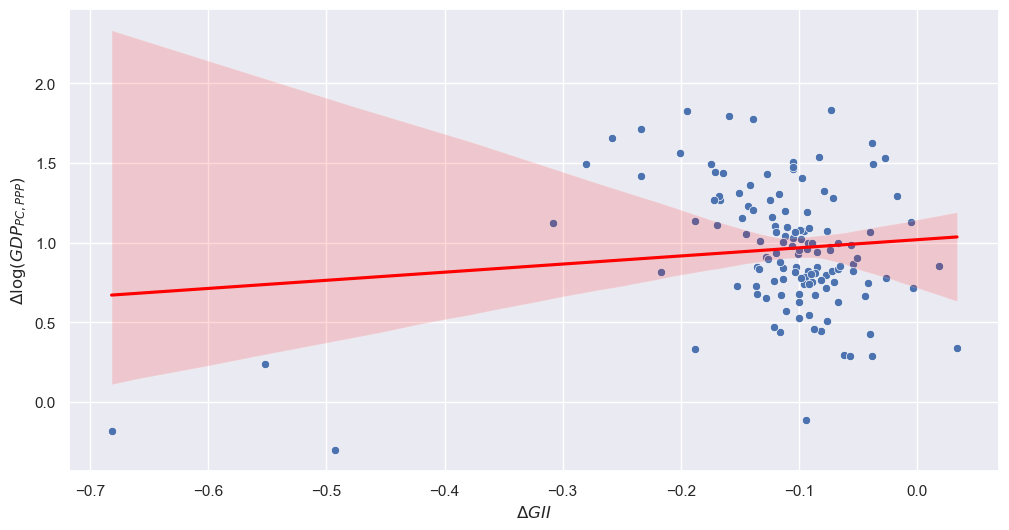

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=GAP_GDP_GII, y='diff_logGDP', x='diff_Gender Inequality Index (value)')
sns.regplot(data=GAP_GDP_GII, y='diff_logGDP', x='diff_Gender Inequality Index (value)', scatter=False, color='red', line_kws={"label": "Trend Line"})
plt.ylabel(r'$\Delta\log (GDP_{PC,PPP})$')
plt.xlabel(r'$\Delta GII$')

# plt.savefig(image_path + 'HDI_Female_vs_Male.pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
np.corrcoef(GAP_GDP_GII['diff_logGDP'], GAP_GDP_GII['diff_Gender Inequality Index (value)'])

array([[1.        , 0.11488925],
       [0.11488925, 1.        ]])

In [ ]:
Panel_GII = GAP_GDP_GII.copy()
Y = Panel_GII['diff_logGDP']
X = Panel_GII['diff_'+HDR_idx['gii']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.726
Date:                Fri, 16 May 2025   Prob (F-statistic):              0.191
Time:                        18:12:15   Log-Likelihood:                -62.946
No. Observations:                 131   AIC:                             129.9
Df Residuals:                     129   BIC:                             135.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    1.0192      0.057     17.897      0.000       0.907       1.132
diff_Gender Inequality Index (value)     0.5096      0.388      1.314      0.191      -0.258       1.277
==============================================================================
Omnibus:                        0.262   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.051
Skew:                           0.018   Prob(JB):                        0.975
Kurtosis:                       3.091   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Panel_GII_GS = GAP_GDP_GII_GS.copy()
Y = Panel_GII_GS['diff_logGDP']
X = Panel_GII_GS
X.drop(columns=['iso3', 'year_2023', 'logGDP_2023', 'year_2003', 'logGDP_2003',
       'Gender Inequality Index (value)_2023',
       'Gender Inequality Index (value)_2003','diff_logGDP','year'],inplace=True)
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     3.146
Date:                Fri, 16 May 2025   Prob (F-statistic):           6.71e-06
Time:                        18:16:01   Log-Likelihood:                -16.153
No. Observations:                 131   AIC:                             100.3
Df Residuals:                      97   BIC:                             198.1
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
diff_Gender Inequality Index (value)                                                                 -0.0383      0.414     -0.092      0.927      -0.861       0.784
A woman can apply for a passport in the same way as a man (1=yes; 0=no)                               0.1526      0.115      1.323      0.189      -0.076       0.381
A woman can be head of household in the same way as a man (1=yes; 0=no)                              -0.4139      0.195     -2.120      0.037      -0.802      -0.026
A woman can choose where to live in the same way as a man (1=yes; 0=no)                               0.1874      0.147      1.272      0.207      -0.105       0.480
A woman can get a job in the same way as a man (1=yes; 0=no)                                          0.2347      0.277      0.848      0.399      -0.315       0.784
A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)                      -0.0056      0.131     -0.043      0.966      -0.265       0.254
A woman can open a bank account in the same way as a man (1=yes; 0=no)                               -0.3084      0.442     -0.698      0.487      -1.186       0.569
A woman can register a business in the same way as a man (1=yes; 0=no)                               -0.9040      0.551     -1.641      0.104      -1.998       0.190
A woman can sign a contract in the same way as a man (1=yes; 0=no)                                    1.4070      0.666      2.111      0.037       0.084       2.730
A woman can travel outside her home in the same way as a man (1=yes; 0=no)                            0.4636      0.344      1.346      0.181      -0.220       1.147
A woman can travel outside the country in the same way as a man (1=yes; 0=no)                         0.5638      0.279      2.018      0.046       0.009       1.118
A woman can work at night in the same way as a man (1=yes; 0=no)                                     -0.0177      0.149     -0.119      0.906      -0.313       0.278
A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no)                    -0.0259      0.101     -0.256      0.799      -0.227       0.175
A woman can work in an industrial job in the same way as a man (1=yes; 0=no)                         -0.0136      0.087     -0.157      0.875      -0.185       0.158
A woman has the same rights to remarry as a man (1=yes; 0=no)                                        -0.0541      0.093     -0.581      0.562      -0.239       0.131
Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no)   

## Multicollinearity

In [ ]:
Sigma = Panel_GII_GS.corr(method='pearson').abs()
Sigma.values.diagonal().sum() == len(Panel_GII_GS.columns) # Check if the diagonal is 1
np.fill_diagonal(Sigma.values, np.nan)
Sigma.style.background_gradient(cmap='coolwarm', axis=None)

,diff_Gender Inequality Index (value),A woman can apply for a passport in the same way as a man (1=yes; 0=no),A woman can be head of household in the same way as a man (1=yes; 0=no),A woman can choose where to live in the same way as a man (1=yes; 0=no),A woman can get a job in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can open a bank account in the same way as a man (1=yes; 0=no),A woman can register a business in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can travel outside her home in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work at night in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),Dismissal of pregnant workers is prohibited (1=yes; 0=no),Female and male surviving spouses have equal rights to inherit assets (1=yes; 0=no),Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no),Law prohibits discrimination in employment based on gender (1=yes; 0=no),Men and married women have equal ownership rights to immovable property (1=yes; 0=no),Paid leave is available to fathers (1=yes; 0=no),Paid leave of at least 14 weeks available to mothers (1=yes; 0=no),Sons and daughters have equal rights to inherit assets from their parents (1=yes; 0=no),The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no),The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),The government administers 100% of maternity leave benefits (1=yes; 0=no),The law grants spouses equal administrative authority over assets during marriage (1=yes; 0=no),The law prohibits discrimination in access to credit based on gender (1=yes; 0=no),The mandatory retirement age for men and women is the same (1=yes; 0=no),There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no),There is legislation on sexual harassment in employment (1=yes; 0=no),There is legislation specifically addressing domestic violence (1=yes; 0=no),There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no),There is paid parental leave (1=yes; 0=no)
diff_Gender Inequality Index (value),nan,0.141905,0.074532,0.138478,0.173266,0.265388,0.052712,0.006017,nan,0.150685,0.158136,0.146078,0.120067,0.088846,0.285267,0.008178,0.100148,0.390032,0.036398,0.076997,0.036824,0.056066,0.109714,0.362436,0.046546,0.064490,0.162495,0.036824,0.028807,0.098280,0.003817,0.100927,0.015243,0.275156,0.008581
A woman can apply for a passport in the same way as a man (1=yes; 0=no),0.141905,nan,0.135127,0.158721,0.186657,0.338820,0.150743,0.031539,nan,0.108522,0.053486,0.091881,0.104905,0.028015,0.119184,0.201529,0.305147,0.094974,0.131262,0.108398,0.265239,0.306908,0.185302,0.159105,0.108672,0.046361,0.106214,0.265239,0.234592,0.041010,0.048821,0.263590,0.167471,0.077188,0.287116
A woman can be head of household in the same way as a man (1=yes; 0=no),0.074532,0.135127,nan,0.366449,0.646075,0.350847,0.392106,0.027851,nan,0.471574,0.489197,0.332222,0.286295,0.140487,0.413418,0.123240,0.285633,0.565253,0.158811,0.147117,0.436761,0.022884,0.140487,0.565253,0.006806,0.150394,0.072087,0.436761,0.217916,0.071619,0.057741,0.147117,0.506661,0.506661,0.199274
A woman can choose where to live in the same way as a man (1=yes; 0=no),0.138478,0.158721,0.366449,nan,0.543838,0.374197,0.333817,0.032714,nan,0.586368,0.534058,0.175182,0.260462,0.063049,0.401814,0.064405,0.288043,0.393706,0.013342,0.172805,0.252823,0.024904,0.165018,0.3937

In [ ]:
for each in Sigma.columns:
    if Sigma[each].max() > 0.9:
        Sigma.drop(each, axis=1, inplace=True)
features = Sigma.columns
Sigma.style.background_gradient(cmap='coolwarm', axis=None)

,diff_Gender Inequality Index (value),A woman can apply for a passport in the same way as a man (1=yes; 0=no),A woman can be head of household in the same way as a man (1=yes; 0=no),A woman can choose where to live in the same way as a man (1=yes; 0=no),A woman can get a job in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can open a bank account in the same way as a man (1=yes; 0=no),A woman can register a business in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can travel outside her home in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work at night in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),Dismissal of pregnant workers is prohibited (1=yes; 0=no),Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no),Law prohibits discrimination in employment based on gender (1=yes; 0=no),Paid leave is available to fathers (1=yes; 0=no),Paid leave of at least 14 weeks available to mothers (1=yes; 0=no),The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no),The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),The government administers 100% of maternity leave benefits (1=yes; 0=no),The law prohibits discrimination in access to credit based on gender (1=yes; 0=no),The mandatory retirement age for men and women is the same (1=yes; 0=no),There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no),There is legislation on sexual harassment in employment (1=yes; 0=no),There is legislation specifically addressing domestic violence (1=yes; 0=no),There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no),There is paid parental leave (1=yes; 0=no)
diff_Gender Inequality Index (value),nan,0.141905,0.074532,0.138478,0.173266,0.265388,0.052712,0.006017,nan,0.150685,0.158136,0.146078,0.120067,0.088846,0.285267,0.008178,0.100148,0.036398,0.076997,0.056066,0.109714,0.046546,0.064490,0.162495,0.028807,0.098280,0.003817,0.100927,0.015243,0.275156,0.008581
A woman can apply for a passport in the same way as a man (1=yes; 0=no),0.141905,nan,0.135127,0.158721,0.186657,0.338820,0.150743,0.031539,nan,0.108522,0.053486,0.091881,0.104905,0.028015,0.119184,0.201529,0.305147,0.131262,0.108398,0.306908,0.185302,0.108672,0.046361,0.106214,0.234592,0.041010,0.048821,0.263590,0.167471,0.077188,0.287116
A woman can be head of household in the same way as a man (1=yes; 0=no),0.074532,0.135127,nan,0.366449,0.646075,0.350847,0.392106,0.027851,nan,0.471574,0.489197,0.332222,0.286295,0.140487,0.413418,0.123240,0.285633,0.158811,0.147117,0.022884,0.140487,0.006806,0.150394,0.072087,0.217916,0.071619,0.057741,0.147117,0.506661,0.506661,0.199274
A woman can choose where to live in the same way as a man (1=yes; 0=no),0.138478,0.158721,0.366449,nan,0.543838,0.374197,0.333817,0.032714,nan,0.586368,0.534058,0.175182,0.260462,0.063049,0.401814,0.064405,0.288043,0.013342,0.172805,0.024904,0.165018,0.073450,0.116390,0.228108,0.161244,0.032142,0.080257,0.097347,0.419539,0.595129,0.297818
A woman can get a job in the same way as a man (1=yes; 0=no),0.173266,0.186657,0.646075,0.543838,nan,0.447316,0.458436,0.023822,nan,0.686909,0.418416,0.284153,0.373700,0.219160,0.402412,0.105408,0.267346,0.135832,0.101410,0.030703,0.153160,0.005821,0.050620,0.092603,0.140403,0.010787,0.065361,0.199092,0.490179,0.717483,0.216861
A woman can obtain a judgment of divorce in the same way as a man 

In [ ]:
X_new = vif_selection(Panel_GII_GS[features], thresh=5.0)

Dropping 'A woman can sign a contract in the same way as a man (1=yes; 0=no)' (VIF = 386.15)
Dropping 'A woman can open a bank account in the same way as a man (1=yes; 0=no)' (VIF = 130.54)
Dropping 'A woman can travel outside her home in the same way as a man (1=yes; 0=no)' (VIF = 107.84)
Dropping 'A woman can travel outside the country in the same way as a man (1=yes; 0=no)' (VIF = 71.86)


Dropping 'A woman can get a job in the same way as a man (1=yes; 0=no)' (VIF = 50.00)
Dropping 'A woman can register a business in the same way as a man (1=yes; 0=no)' (VIF = 42.04)
Dropping 'There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no)' (VIF = 34.90)
Dropping 'There is legislation on sexual harassment in employment (1=yes; 0=no)' (VIF = 27.64)
Dropping 'There is legislation specifically addressing domestic violence (1=yes; 0=no)' (VIF = 23.04)
Dropping 'A woman can work at night in the same way as a man (1=yes; 0=no)' (VIF = 21.08)
Dropping 'A woman can be head of household in the same way as a man (1=yes; 0=no)' (VIF = 15.70)
Dropping 'The mandatory retirement age for men and women is the same (1=yes; 0=no)' (VIF = 13.22)
Dropping 'Law prohibits discrimination in employment based on gender (1=yes; 0=no)' (VIF = 12.63)
Dropping 'A woman can apply for a passport in the same way as a man (1=yes; 0=no)' (VIF = 11.74)
Dropping 'A woman can ch

In [ ]:
Panel_GII_GS = GAP_GDP_GII_GS.copy()
Y = Panel_GII_GS['diff_logGDP']
X = sm.add_constant(X_new)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     4.866
Date:                Fri, 16 May 2025   Prob (F-statistic):           7.02e-06
Time:                        18:16:02   Log-Likelihood:                -41.519
No. Observations:                 131   AIC:                             105.0
Df Residuals:                     120   BIC:                             136.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                              0.9437      0.132      7.154      0.000       0.683       1.205
diff_Gender Inequality Index (value)                                                               0.1335      0.377      0.354      0.724      -0.613       0.880
A woman can work in an industrial job in the same way as a man (1=yes; 0=no)                      -0.0166      0.074     -0.224      0.823      -0.163       0.130
A woman has the same rights to remarry as a man (1=yes; 0=no)                                      0.1641      0.078      2.102      0.038       0.010       0.319
Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)       -0.0399      0.069     -0.579      0.563      -0.176       0.096
Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)                                 0.2757      0.080      3.443      0.001       0.117       0.434
The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no)    -0.2247      0.069     -3.261      0.001      -0.361      -0.088
The government administers 100% of maternity leave benefits (1=yes; 0=no)                          0.0259      0.077      0.338      0.736      -0.126       0.178
The law prohibits discrimination in access to credit based on gender (1=yes; 0=no)                 0.0271      0.073      0.372      0.711      -0.117       0.172
There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no)    -0.1846      0.071     -2.611      0.010      -0.325      -0.045
There is paid parental leave (1=yes; 0=no)                                                        -0.0042      0.087     -0.049      0.961      -0.176       0.167
==============================================================================
Omnibus:                        5.506   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                6.740
Skew:                          -0.223   Prob(JB):                       0.0344
Kurtosis:                       4.018   Cond. No.                         28.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X_selected = pvalue_selection(X_new, Y, thresh=0.10)
model = sm.OLS(Panel_GII_GS['diff_logGDP'], X_selected).fit()
model.summary()

Dropping 'There is paid parental leave (1=yes; 0=no)' (p = 0.9612)
Dropping 'A woman can work in an industrial job in the same way as a man (1=yes; 0=no)' (p = 0.8219)
Dropping 'The law prohibits discrimination in access to credit based on gender (1=yes; 0=no)' (p = 0.7511)
Dropping 'The government administers 100% of maternity leave benefits (1=yes; 0=no)' (p = 0.7538)
Dropping 'diff_Gender Inequality Index (value)' (p = 0.6739)
Dropping 'Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)' (p = 0.5546)
All predictors have p-value ≤ 0.1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     12.50
Date:                Fri, 16 May 2025   Prob (F-statistic):           1.36e-08
Time:                        18:16:02   Log-Likelihood:                -41.932
No. Observations:                 131   AIC:                             93.86
Df Residuals:                     126   BIC:                             108.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                              0.9198      0.091     10.105      0.000       0.740       1.100
A woman has the same rights to remarry as a man (1=yes; 0=no)                                      0.1700      0.065      2.627      0.010       0.042       0.298
Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)                                 0.2831      0.069      4.109      0.000       0.147       0.419
The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no)    -0.2326      0.064     -3.620      0.000      -0.360      -0.105
There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no)    -0.1853      0.065     -2.851      0.005      -0.314      -0.057
==============================================================================
Omnibus:                        6.830   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                9.306
Skew:                          -0.254   Prob(JB):                      0.00953
Kurtosis:                       4.203   Cond. No.                         6.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
GAP_GDP_GII

,iso3,year_2023,logGDP_2023,year_2003,logGDP_2003,Gender Inequality Index (value)_2023,Gender Inequality Index (value)_2003,diff_logGDP,diff_Gender Inequality Index (value)
1,ALB,2023,9.962144,2003,8.517262,0.107,0.278,1.444882,-0.171
2,DZA,2023,9.730591,2003,9.287556,0.443,0.559,0.443035,-0.116
6,ARG,2023,10.311692,2003,9.299577,0.264,0.397,1.012115,-0.133
7,ARM,2023,9.968456,2003,8.252244,0.180,0.414,1.716212,-0.234
8,AUS,2023,11.161099,2003,10.313005,0.056,0.141,0.848094,-0.085
...,...,...,...,...,...,...,...,...,...
174,URY,2023,10.446585,2003,9.240213,0.218,0.357,1.206372,-0.139
175,UZB,2023,9.315328,2003,8.021994,0.291,0.308,1.293334,-0.017
177,VNM,2023,9.614063,2003,8.083258,0.299,0.326,1.530805,-0.027
179,ZMB,2023,8.313115,2003,7.571584,0.524,0.615,0.741531,-0.091
